## Preparation

In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import cv2

In [5]:
device=torch.device('cuda:0') #先調1再調0

In [6]:
print(torch.cuda.is_available())

True


In [7]:
x=torch.randn(1000, 6724)
x=x.to(device)

## Data

In [8]:
# Step 1. Prepare data-1/2
# DataLoader wraps a Dataset and provides minibatches, shuffling, multithreading, for you
data_in=np.loadtxt('./data/preserved/input_div_U_2_1s.dat')
data_out=np.loadtxt('./data/preserved/input_div_U_2_1s.dat')
x_in=torch.Tensor(data_in)
y_in=torch.Tensor(data_out)
x_in=x_in.to(device)
y_in=y_in.to(device)

In [9]:
x=x_in
y=y_in
print(x.size())
print(y.size())
loader=DataLoader(TensorDataset(x, y), batch_size=200)

torch.Size([1000, 6400])
torch.Size([1000, 6400])


## Model

In [10]:
# Step 2. Create model 建立model習慣建立class
class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, B, D_out):
        super(TwoLayerNet, self).__init__()
        self.linear_1=torch.nn.Linear(D_in, H)
        self.linear_2=torch.nn.Linear(H, B)
        self.linear_3=torch.nn.Linear(B, D_out)
    
    # Step 3. Forward pass-1/2    # Step 4. Backward pass-1/2
    def forward(self, x):
        h=self.linear_1(x)
        h_relu=torch.nn.functional.relu(h) #為何activation and hidden layer 的實現方式不同
        b=self.linear_2(h_relu) 
        b_relu=torch.nn.functional.relu(b)
        y_pred=self.linear_3(b_relu) 
        return y_pred
    
model= TwoLayerNet(D_in=6400, H=1000, B=1000, D_out=6400)
model=model.to(device) #這行是什麼意思? A:将模型加载到相应的设备

In [14]:
x= torch.nn.Sequential(torch.nn.Unflatten(1, (1,80,80)))(x)
# Convolutional neural network (two convolutional layers)
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(torch.nn.Module):
    def __init__(self, channel_1, channel_2, kernel_dim):
        super(ConvNet, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, channel_1, kernel_dim)
        self.conv2 = nn.Conv2d(channel_1, channel_2, kernel_dim)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(78*78*3, 1000)  # 78*78 from image dimension
        self.fc2 = nn.Linear(1000, 1000)
        self.fc3 = nn.Linear(1000, 6400)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = ConvNet(channel_1=3, channel_2=3, kernel_dim=3).to(device)

## Training

In [11]:
tol=1e-3

In [12]:
optimizer=torch.optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

In [13]:
optimizer=torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)

In [14]:
loss_epoch=[]
loss_values = []
loss=1
epochs=0

print("Epochs    Loss")

while(loss>tol):
    epochs=epochs+1
    scheduler.step()
    
    for x_batch, y_batch in loader:
        # Forward pass
        y_pred=model(x_batch)
        #print(x_batch.size(dim=0))
        #print(y_pred.size())
        
        #L_y_pred=y_pred #RHP*dt
        #L_y_pred=y_pred*0.001*80*80 #RHP*dt
        #L_y_pred=LAPLACIAN(y_pred)*0.001 #RHP*dt
        #L_y_pred=numpy_test(y_pred, 80) #RHP*dt
        #L_y_pred=LAP(y_pred, 80)*0.001*80*80 #RHP*dt
        
        #print(type(L_y_pred), L_y_pred)
        #print("LP 1 batch")
        #print(L_y_pred.type())
        #y_pred=torch.tensor(y_pred, requires_grad=False)
        loss=torch.nn.functional.mse_loss(y_pred, x_batch)
        #loss=torch.nn.functional.l1_loss(y_pred, y_pred+x_batch-L_y_pred)
        
        # Backward pass
        loss.requires_grad_(True)
        loss.backward()
        
        # Update Weights
        optimizer.step()
        optimizer.zero_grad()
        #print("1 batch")
    
    loss_epoch.append(epochs)
    loss_values.append(loss.item())
    
    if epochs%1==0:
        print("Epochs: ", epochs, "; Loss: ", loss.item())
        
    loss=loss.item()

print(epochs, "    ", loss.item())

#Plot loss function
from matplotlib import pyplot as plt
plt.plot(loss_epoch, loss_values)
plt.xlabel('epochs')
plt.ylabel('loss')

Epochs    Loss


C:\Users\ENCHOU\anaconda3\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epochs:  1 ; Loss:  0.07706636190414429
Epochs:  2 ; Loss:  0.0736662968993187
Epochs:  3 ; Loss:  0.06858031451702118
Epochs:  4 ; Loss:  0.060844119638204575
Epochs:  5 ; Loss:  0.05071916803717613
Epochs:  6 ; Loss:  0.039850398898124695
Epochs:  7 ; Loss:  0.029738062992691994
Epochs:  8 ; Loss:  0.020333200693130493
Epochs:  9 ; Loss:  0.012046345509588718
Epochs:  10 ; Loss:  0.0063999793492257595
Epochs:  11 ; Loss:  0.003471886273473501
Epochs:  12 ; Loss:  0.0016378260916098952
Epochs:  13 ; Loss:  0.0006888867355883121


AttributeError: 'float' object has no attribute 'item'

## Result

[]

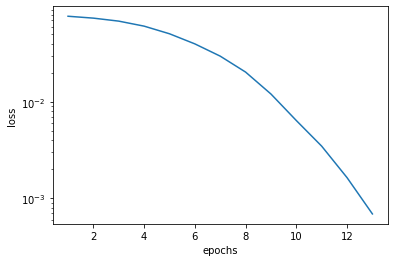

In [15]:
#Plot loss function
from matplotlib import pyplot as plt
plt.plot(loss_epoch, loss_values)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.semilogy()

## Export

In [17]:
device=torch.device('cpu')
model=model.to(device)
PATH= "model_jit_xx.pth"
traced_net=torch.jit.trace(model, (torch.randn(1,6400)).to(device))
traced_net.to(torch.float64)
torch.jit.save(traced_net, PATH)